In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,precision_score,accuracy_score,classification_report,roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data_cleaned.csv')

## Data Preprocessing for Training

In [3]:
# Data Preprocessing
df_normal = df[df['label'] == 0]
df_anomalous = df[df['label'] == 1]
df_normal = df_normal.drop(columns=['label'])
df_anomalous = df_anomalous.drop(columns=['label'])
# Data Distribution
print(f"Normal: {len(df_normal)}, Anomalous: {len(df_anomalous)}")

Normal: 569877, Anomalous: 20663


## Training the Model

- **K-fold cross-validation** was used to ensure the model was trained on different subsets of the data. Since only a subset of the normal class was used for testing, relying on a single split might not provide the most reliable results. K-fold cross-validation helps mitigate this issue by training the model across multiple data folds, leading to a more robust evaluation.

In [11]:
# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Initialize an empty list to store the results
results = []
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    # Split the data into training and test sets
    X_train, X_test = df_normal.iloc[train_index], df_normal.iloc[test_index]
    y_test = np.full(len(X_test), 0)
    # add anomalous data to the test set
    X_test = pd.concat([X_test, df_anomalous])
    y_test = np.concatenate([y_test, np.full(len(df_anomalous), 1)])
    
    # Train the Isolation Forest model
    model = IsolationForest(contamination=0.2, random_state=42, n_jobs=-1)
    model.fit(X_train)
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append({
        'f1': f1,
        'precision': precision,
        'accuracy': accuracy
    })
    
print(f"F1 Score: {np.mean([result['f1'] for result in results])}")
print(f"Precision: {np.mean([result['precision'] for result in results])}")
print(f"Accuracy: {np.mean([result['accuracy'] for result in results])}")
print(f"Classification Report: {classification_report(y_test, y_pred)}")

F1 Score: 0.5035340228687739
Precision: 0.4861735830721566
Accuracy: 0.7260024748573087
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.80      0.81     56987
           1       0.49      0.53      0.51     20663

    accuracy                           0.73     77650
   macro avg       0.66      0.66      0.66     77650
weighted avg       0.74      0.73      0.73     77650



## Hyperparameter Tuning

In [ ]:
# Objective function for Optuna
def objective(trial):
    contamination = trial.suggest_float('contamination', 0.1, 0.5, step=0.1)
    n_estimators = trial.suggest_int('n_estimators', 50, 800, step=50)
    max_features = trial.suggest_float('max_features', 0.1, 1.0, step=0.1)
    
    
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    f1_scores = []
    precisions = []
    accuracies = []
    
    for train_index, test_index in kf.split(df_normal):
        # Data preparation
        X_train = df_normal.iloc[train_index]
        X_test_normal = df_normal.iloc[test_index]
        
        # Create test set with anomalies
        X_test = pd.concat([X_test_normal, df_anomalous])
        y_test = np.concatenate([np.zeros(len(X_test_normal)), 
                               np.ones(len(df_anomalous))])
        
        # Initialize and train Isolation Forest model
        model = IsolationForest(
            contamination=contamination,
            n_estimators=n_estimators,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_train)
        
        # Predict the labels for the test set
        y_pred = model.predict(X_test)
        y_pred = [1 if x == -1 else 0 for x in y_pred]
        
        # Calculate metrics
        f1_scores.append(f1_score(y_test, y_pred, pos_label=1))
        precisions.append(precision_score(y_test, y_pred, pos_label=1))
        accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate mean metrics across folds
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precisions)
    avg_accuracy = np.mean(accuracies)
    
    # Return sum of metrics for optimization
    return avg_f1 + avg_precision + avg_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage='sqlite:///if_IEEE.db', load_if_exists=True, study_name="if_IEEE")
study.optimize(objective, n_trials=100)
# Print the best parameters
print("Best trial:")
print("  Value: {}".format(study.best_trial.value))
print("  Params:")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[[51249  5738]
 [12419  8244]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85     56987
           1       0.59      0.40      0.48     20663

    accuracy                           0.77     77650
   macro avg       0.70      0.65      0.66     77650
weighted avg       0.75      0.77      0.75     77650

0.7661687057308435
AUC:  0.6491421902748531


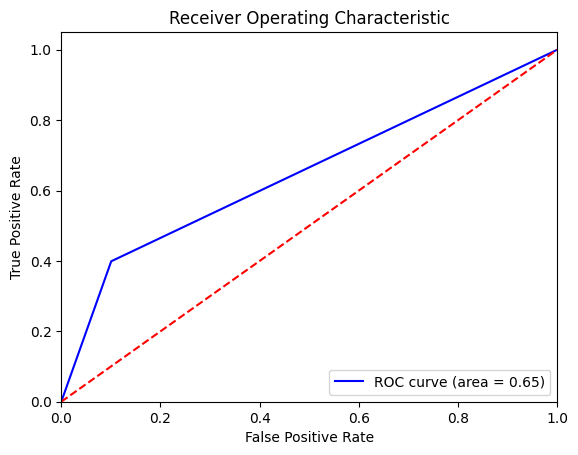

In [ ]:
# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Initialize an empty list to store the results
results = []
# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    # Split the data into training and test sets
    X_train, X_test = df_normal.iloc[train_index], df_normal.iloc[test_index]
    y_test = np.full(len(X_test), 0)
    # add anomalous data to the test set
    X_test = pd.concat([X_test, df_anomalous])
    y_test = np.concatenate([y_test, np.full(len(df_anomalous), 1)])
    
    # Train the Isolation Forest model
    model = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1, n_estimators=150, max_features=0.4)
    model.fit(X_train)
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the results to the list
    results.append({
        'f1': f1,
        'precision': precision,
        'accuracy': accuracy
    })
    
print(f"F1 Score: {np.mean([result['f1'] for result in results])}")
print(f"Precision: {np.mean([result['precision'] for result in results])}")
print(f"Accuracy: {np.mean([result['accuracy'] for result in results])}")
print(f"Classification Report: {classification_report(y_test, y_pred)}")

## Trainging and Validation difference in prediction

In [5]:
# Storage variables
train_scores = []
test_scores = []
test_labels = []

all_y_test = []
all_y_pred = []
all_y_pred_train = []
all_y_test_train = []

# Store plot data for first 5 folds
fold_plots_data = []

# Create a KFold object with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)
n = 0

# Iterate through the folds
for train_index, test_index in kf.split(df_normal):
    n += 1
    
    # Data preparation
    X_train = df_normal.iloc[train_index]
    X_test_normal = df_normal.iloc[test_index]
    
    # Create test set with anomalies
    X_test = pd.concat([X_test_normal, df_anomalous])
    y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(df_anomalous))])
    
    # Train model
    model = IsolationForest(contamination=0.1, random_state=42, n_jobs=-1, n_estimators=150, max_features=0.4)
    model.fit(X_train)
    
    # Get scores
    train_score = model.decision_function(X_train)
    test_score = model.decision_function(X_test)
    
    # Store aggregate scores
    train_scores.extend(train_score)
    test_scores.extend(test_score)
    test_labels.extend(y_test)  # Already contains 0s and 1s in order
    
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    
    y_pred_train = model.predict(X_train)
    y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]
    
    
    # Store classification data
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_pred_train.extend(y_pred_train)
    all_y_test_train.extend([0]*len(X_train))
    
    # Store plot data for first 5 folds
    if n <= 5:
        fold_data = {
            'train_scores': train_score.tolist(),
            'train_pred': y_pred_train,
            'test_scores': test_score.tolist(),
            'test_actual': y_test.tolist(),
            'test_pred': y_pred
        }
        fold_plots_data.append(fold_data)

# Store aggregated histogram data
histogram_data = {
    'train_scores': train_scores,
    'test_scores': test_scores,
    'test_labels': test_labels
}

# Store classification reports
test_clf_report = classification_report(all_y_test, all_y_pred, output_dict=True)
train_clf_report = classification_report(all_y_test_train, all_y_pred_train, output_dict=True)

# Combine all stored results
stored_results = {
    'fold_plots_data': fold_plots_data,
    'histogram_data': histogram_data,
    'classification_reports': {
        'test': test_clf_report,
        'train': train_clf_report
    }
}

/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pranav/anaconda3/envs/bytive/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pickle
# Save the results to a file
with open('isf_results.pkl', 'wb') as f:
    pickle.dump(stored_results, f)

In [4]:
import pickle

stored_results = pickle.load(open('autoencoder_results.pkl', 'rb'))

In [12]:
def plot_fast_fold(fold_data, fold_num, subsample_factor=10,subsample_factor_train =100):
    """Plot fold data with original styling but optimized rendering"""
    plt.figure(figsize=(12, 6))
    
    # Training data (always blue)
    train_scores = np.array(fold_data['train_scores'][::subsample_factor_train])
    train_pred = np.array(fold_data['train_pred'][::subsample_factor_train])
    
    # Split training into predicted normal/anomalous
    train_normal = train_pred == 0
    train_anomalies = train_pred == 1
    
    # Plot training normals (circles)
    plt.scatter(np.where(train_normal)[0], train_scores[train_normal],
                color='blue', marker='o', alpha=0.5, s=10, label='Train Normal')
    
    # Plot training anomalies (crosses)
    if np.any(train_anomalies):
        plt.scatter(np.where(train_anomalies)[0], train_scores[train_anomalies],
                    color='blue', marker='x', alpha=0.8, s=30, label='Train Anomalies')

    # Test data
    test_scores = np.array(fold_data['test_scores'][::subsample_factor])
    test_actual = np.array(fold_data['test_actual'][::subsample_factor])
    test_pred = np.array(fold_data['test_pred'][::subsample_factor])
    offset = len(train_scores)
    
    # Create test indices
    test_indices = np.arange(offset, offset + len(test_scores))
    
    # Split test data into 4 groups
    normal_normal = (test_actual == 0) & (test_pred == 0)
    normal_anomaly = (test_actual == 0) & (test_pred == 1)
    anomaly_anomaly = (test_actual == 1) & (test_pred == 1)
    anomaly_normal = (test_actual == 1) & (test_pred == 0)
    
    # Plot test normal-correct (green circles)
    plt.scatter(test_indices[normal_normal], test_scores[normal_normal],
                color='green', marker='o', alpha=0.5, s=10, label='Test Normal Correct')
    
    # Plot test normal-incorrect (green x)
    if np.any(normal_anomaly):
        plt.scatter(test_indices[normal_anomaly], test_scores[normal_anomaly],
                    color='green', marker='x', alpha=0.8, s=30, label='Test Normal Wrong')
    
    # Plot test anomaly-correct (red x)
    if np.any(anomaly_anomaly):
        plt.scatter(test_indices[anomaly_anomaly], test_scores[anomaly_anomaly],
                    color='red', marker='x', alpha=0.8, s=30, label='Test Anomaly Correct')
    
    # Plot test anomaly-incorrect (red circles)
    if np.any(anomaly_normal):
        plt.scatter(test_indices[anomaly_normal], test_scores[anomaly_normal],
                    color='red', marker='o', alpha=0.5, s=10, label='Test Anomaly Wrong')

    plt.title("Anomaly Scores (Actual vs Predicted)")
    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.grid(True)

    # Create simplified legend
    handles = [
        plt.Line2D([], [], color='blue', marker='o', linestyle='', label='Train Normal'),
        plt.Line2D([], [], color='blue', marker='x', linestyle='', label='Train Anomaly'),
        plt.Line2D([], [], color='green', marker='o', linestyle='', label='Normal'),
        plt.Line2D([], [], color='green', marker='x', linestyle='', label='Normal Pred Wrong'),
        plt.Line2D([], [], color='red', marker='x', linestyle='', label='Anomaly'),
        plt.Line2D([], [], color='red', marker='o', linestyle='', label='Anomaly Pred Wrong')
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_fast_histograms(hist_data):
    """Histogram plot with original color scheme"""
    plt.figure(figsize=(10, 6))
    
    sns.histplot(hist_data['train_scores'], color='blue', 
                 label='Train (Normal)', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 0],
                 color='green', label='Test Normal', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 1],
                 color='red', label='Test Anomalous', kde=True, element='step')
    
    plt.title('Aggregated Anomaly Score Distributions (Original Style)')
    plt.legend()
    plt.ylim(0, 10000)
    plt.xlim(0, 0.5)
    plt.show()

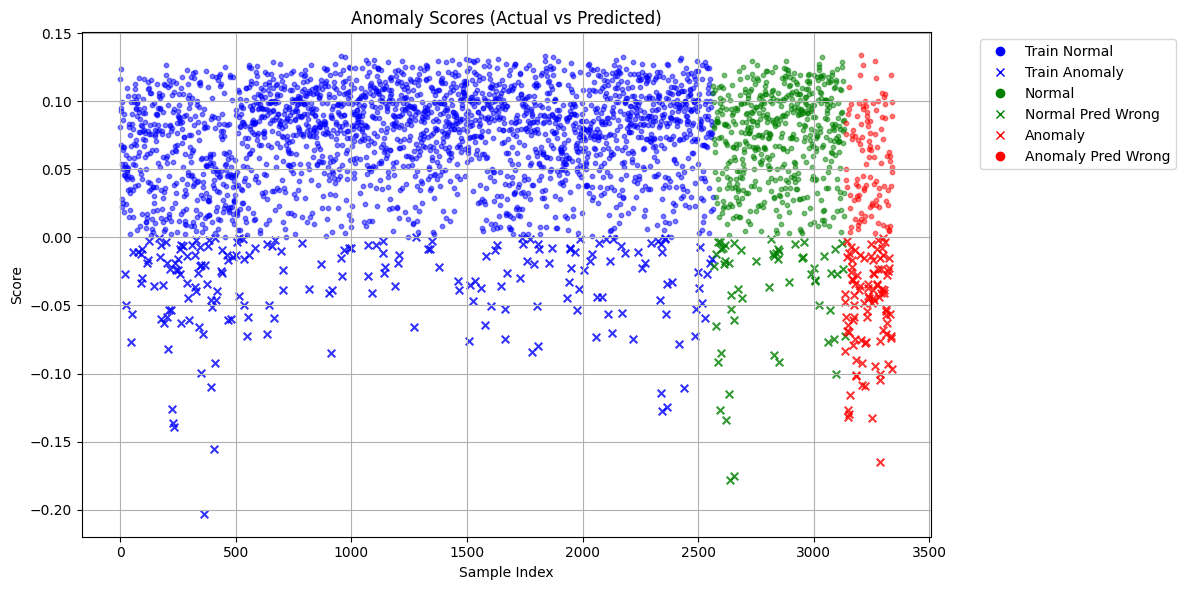

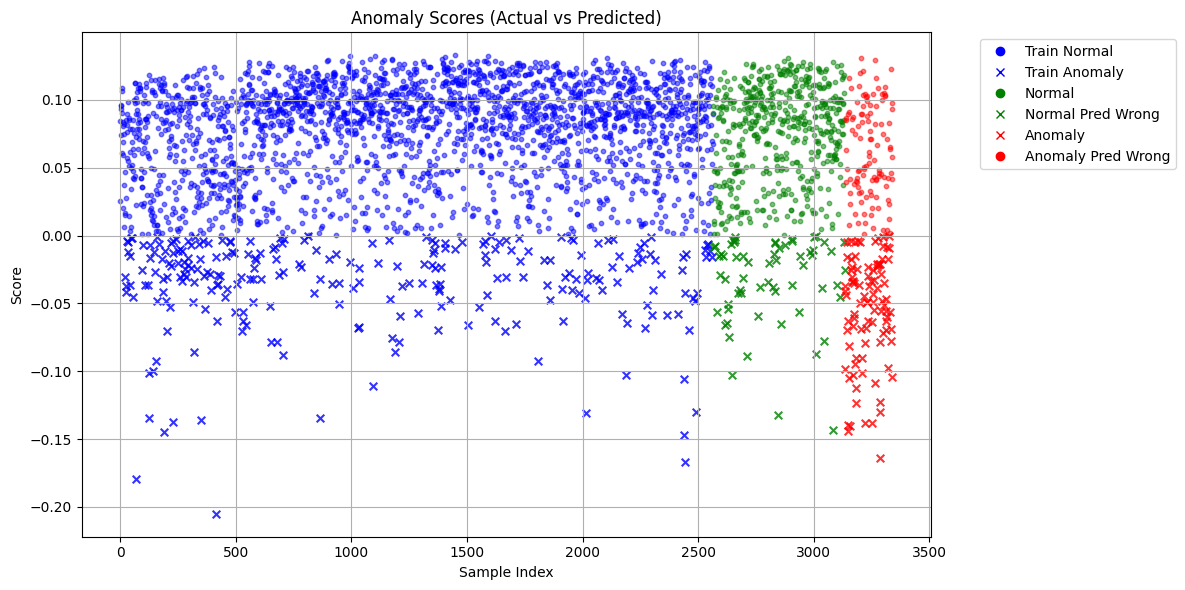

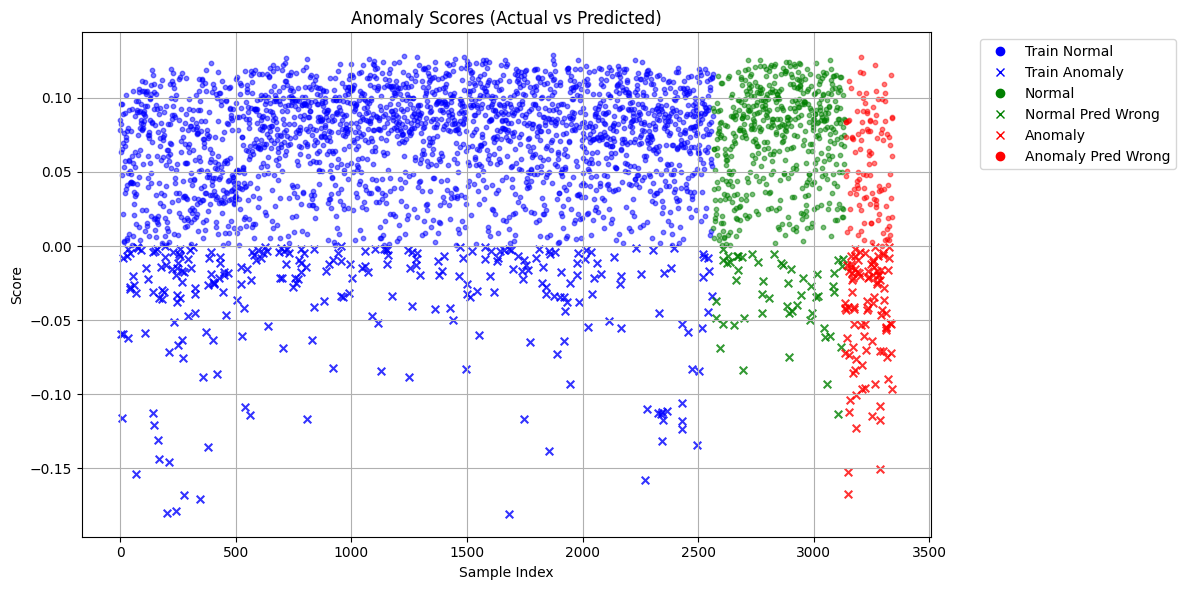

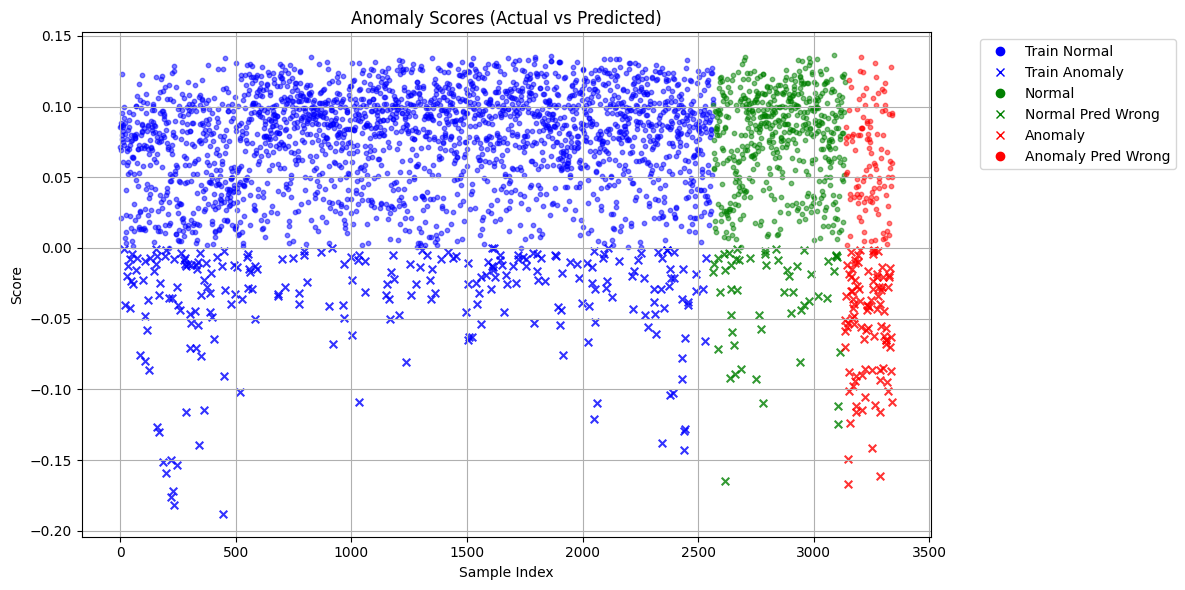

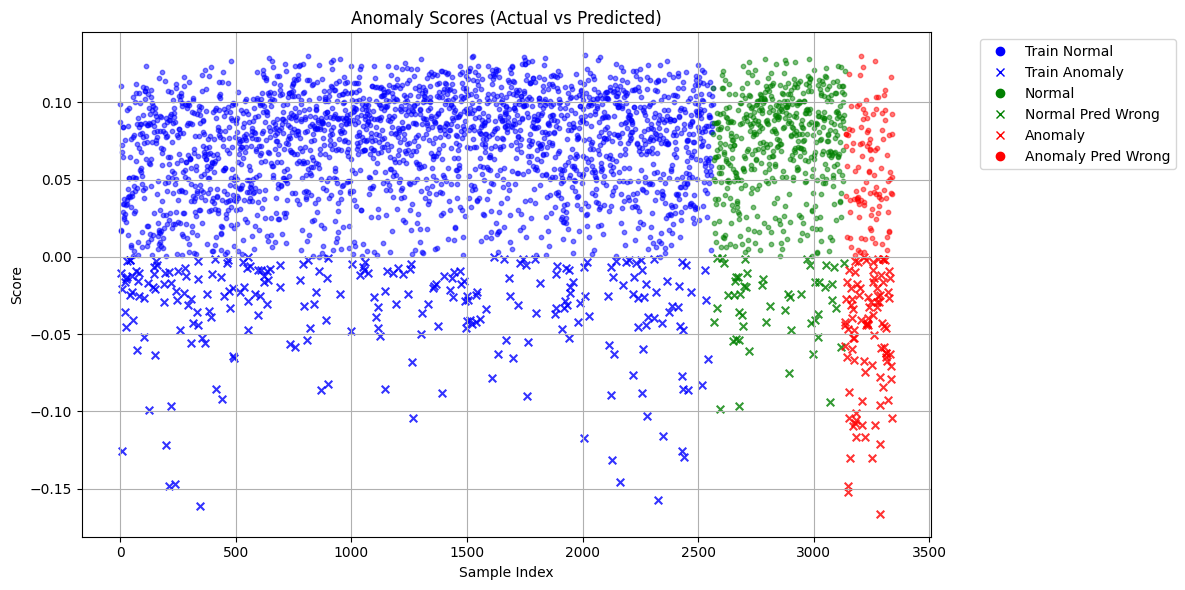

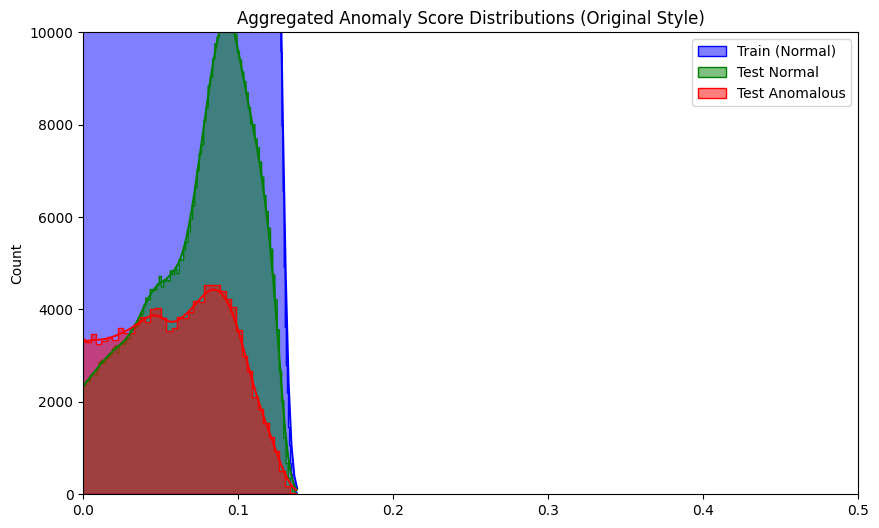

In [13]:
# Plot first 5 folds with subsampling
for i, fold_data in enumerate(stored_results['fold_plots_data'][:5]):
    plot_fast_fold(fold_data, i+1, subsample_factor=100,subsample_factor_train=200)  # Adjust factor as needed

# Plot optimized histograms
plot_fast_histograms(stored_results['histogram_data'])

In [6]:
stored_results['classification_reports']['train']

{'0': {'precision': 1.0,
  'recall': 0.899999863518307,
  'f1-score': 0.9473683454394998,
  'support': 5128893.0},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'accuracy': 0.899999863518307,
 'macro avg': {'precision': 0.5,
  'recall': 0.4499999317591535,
  'f1-score': 0.4736841727197499,
  'support': 5128893.0},
 'weighted avg': {'precision': 1.0,
  'recall': 0.899999863518307,
  'f1-score': 0.9473683454394998,
  'support': 5128893.0}}